# IMPORTS

In [1]:
# \\  -------- IMPORTS -------- //

from ast import Return
from codecs import getdecoder
from pkgutil import get_data
from typing import List
from unicodedata import name
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt



import backtrader as bt
import talib

# cyclical imports
from statsmodels.tsa.filters.hp_filter import hpfilter


# for outliers in data cleaning
from scipy import stats

# Data API
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

df = 0
df1 = 0

end = dt.datetime.now()  # end date is now
start = dt.datetime(1980, 1, 1)   # start date 


# IMPORTING DATA

In [76]:
# import asset data
data = yfin.download(("SPY", 'DX-Y.NYB', 'CL=F', 'GBPUSD=X', 'BTC-USD'), start="2004-01-01", end= dt.datetime.now())

data_1 = pd.DataFrame(data["Close"])

# clean the data

df_asset = data_1.asfreq('D')

df_asset = df_asset.interpolate(method = 'linear') # fill gaps to the correct frequency

df_asset = df_asset.fillna(method = 'ffill')

df_asset = df_asset.fillna(method = 'backfill')

df_asset = df_asset[(np.abs(stats.zscore(df_asset)) < 10).all(axis=1)] # remove any extreme outliers

[*********************100%***********************]  5 of 5 completed


# SELECT ASSET

In [436]:
# select Asset
asset = 'GBPUSD=X'

In [437]:
df_asset[asset].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 7045 entries, 2004-01-01 to 2023-04-15
Freq: D
Series name: GBPUSD=X
Non-Null Count  Dtype  
--------------  -----  
7045 non-null   float64
dtypes: float64(1)
memory usage: 110.1 KB


# Calculating Indicators

In [442]:
# creating ROC indicators
# correlation of Weekly ROC
Fortnitely_roc = df_asset[asset].diff(periods=15)

# correlation of Monthly ROC
monthly_roc = df_asset[asset].diff(periods=30)

# correlation of Quarterly ROC
quarterly_roc = df_asset[asset].diff(periods=90)

# correlation of 6M ROC
half_year_roc = df_asset[asset].diff(periods=180)

# correlation of Yearly ROC
yearly_roc = df_asset[asset].diff(periods=365)

Rate_of_Change_data = pd.concat([Fortnitely_roc, monthly_roc, quarterly_roc, half_year_roc, yearly_roc], axis=1)

new_columns = ['Fortnitely_roc', 'Monthly_roc', 'Quarterly_roc', 'Half_year_roc', 'Yearly_roc']
Rate_of_Change_data.columns = new_columns


In [443]:
# creating volatility indicators
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#create empty DataFrame
volatility_data = pd.DataFrame()

weekly_returns = df_asset[asset].pct_change().dropna()

Window = 15 
volatility_data['V_Fortnitely'] = weekly_returns.rolling(Window).std()
Window_2 = 30
volatility_data['V_Monthly'] = weekly_returns.rolling(Window_2).std()
Window_3 = 60
volatility_data['V_2_Monthly'] = weekly_returns.rolling(Window_3).std()
Window_4 = 90
volatility_data['V_Quarterly'] = weekly_returns.rolling(Window_4).std()
Window_5 = 180
volatility_data['V_Half_Year'] = weekly_returns.rolling(Window_5).std()
Window_6 = 365
volatility_data['V_Year'] = weekly_returns.rolling(Window_6).std()



In [444]:
# ALL INDICATORS IN 1 DATAFRAME

# what relationship - correlation / stationary ?
indicators_df = pd.concat([volatility_data, Rate_of_Change_data], axis=1)

# METHODS OF CHOOSING APPROPRIATE INDICATOR / INDICATORS FOR ASSET

## FINDING THE ROC INDICATOR AND VOLATILITY INDICATOR

In [445]:



# ROC INDICATOR
##############################################################################
# concat indicators with asset

asset_ind = pd.concat([Rate_of_Change_data, df_asset[asset].diff()], axis = 1)

# calculate the correlation
asset_ind_corr = asset_ind.corr()

# extract the column with the asset
corr_coeff = asset_ind_corr[asset]

#sort the values and remove the top row
corr_coeff = pd.DataFrame(corr_coeff)
corr_coeff = corr_coeff.sort_values(by = asset, ascending = False)
corr_coeff = corr_coeff.iloc[1:]

indicator_roc = corr_coeff.index[0]
indicator_roc


'Fortnitely_roc'

In [446]:
# VOL INDICATOR
##############################################################################
# concat indicators with asset

asset_ind_vol = pd.concat([volatility_data, df_asset[asset].diff()], axis = 1)

# calculate the correlation
asset_ind_vol_corr = asset_ind_vol.corr()

# extract the column with the asset
corr_coeff_vol = asset_ind_vol_corr[asset]

#sort the values and remove the top row
corr_coeff_vol = pd.DataFrame(corr_coeff_vol)
corr_coeff_vol = corr_coeff_vol.sort_values(by = asset, ascending = False)
corr_coeff_vol = corr_coeff_vol.iloc[1:]
corr_coeff_vol
#print(corr_coeff_vol)
# Calculate the absolute difference from 1 and -1 for each value
abs_diff_1 = abs(corr_coeff_vol - 1)
abs_diff_minus_1 = abs(corr_coeff_vol + 1)
# Find the minimum absolute difference for each column
min_abs_diff = pd.concat([abs_diff_1.min(), abs_diff_minus_1.min()], axis=1).min(axis=1)

indicator_vol = corr_coeff_vol.index[0]
indicator_vol

'V_Year'

# CREATE THE RULE

## FIND THRESHOLD FOR VOLATILITY

In [447]:
#transform the data
volatility_ind = volatility_data[indicator_vol]
roc_ind = Rate_of_Change_data[indicator_roc]

In [448]:
# mechanism for finding data point to start at where no NaNs appear from the different rates of the indicators

# count how many nans in roc
roc_null = roc_ind.isnull().sum()
#count how many nans in volatility_data
vol_null = volatility_ind.isnull().sum()
#find the biggest an take that many rows off the start off both them

# create empty val
remove = 0
if roc_null > vol_null:
    remove = roc_null
else:
    remove = vol_null

roc_ind = roc_ind[remove:]
vol_ind = volatility_ind[remove:]
returns = df_asset[asset].diff()
returns = returns[remove + 1:]

<AxesSubplot:xlabel='Date'>

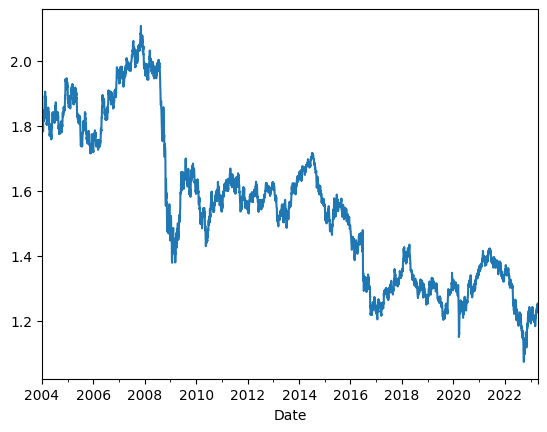

In [458]:
df_asset[asset].plot()

In [459]:
# CHOOSE AMOUNT OF DATA WITH TAIL
# transform data
volatility_array = vol_ind.to_numpy()
# transform data
returns_array = returns.to_numpy()

### DECISION TREE

In [460]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#transform the data
#volatility_ind = volatility_data[indicator_vol]

#returns = df_asset[asset].diff()
#
# transform data
#volatility_array = vol_ind.to_numpy()
# transform data
#returns_array = returns.to_numpy()
n = 1000
# Split the data into training and testing sets
split_idx = int(n * 0.8)
train_returns, test_returns = returns_array[:split_idx], returns_array[split_idx:]
train_volatility, test_volatility = volatility_array[:split_idx], volatility_array[split_idx:]

# Fit decision tree to find best threshold for separating positive and negative returns
tree = DecisionTreeRegressor(max_depth=1, random_state=0)
tree.fit(train_volatility.reshape(-1, 1), train_returns)

# Extract threshold from decision tree
threshold = tree.tree_.threshold[0]

# Make predictions on test data
test_predictions = (test_volatility > threshold).astype(int)

# Compute evaluation metrics
accuracy = accuracy_score(test_returns > 0, test_predictions)
precision = precision_score(test_returns > 0, test_predictions)
recall = recall_score(test_returns > 0, test_predictions)
f1 = f1_score(test_returns > 0, test_predictions)

# Print evaluation metrics
print("Threshold for positive returns:", threshold)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Threshold for positive returns: 0.005227288696914911
Accuracy: 0.5224489795918368
Precision: 0.5173564753004005
Recall: 0.270979020979021
F1 score: 0.3556677374942634


## INDICATOR ENVIRONMENTS

CURRENT: condition_2
ROC 0.013802528381347656
VOL 0.006231250722491618


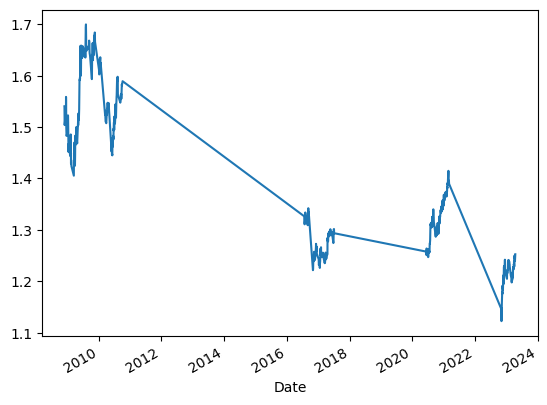

In [462]:
# THE INDICATOR RULE
# Define the rule
condition_1_data = df_asset[asset][(indicators_df[indicator_roc] > 0) & (volatility_ind < threshold)]
condition_2_data = df_asset[asset][(indicators_df[indicator_roc] > 0) & (volatility_ind > threshold)]
condition_3_data = df_asset[asset][(indicators_df[indicator_roc] < 0) & (volatility_ind < threshold)]
condition_4_data = df_asset[asset][(indicators_df[indicator_roc] < 0) & (volatility_ind > threshold)]

# THE INDICATOR RULE
condition_2_data.plot() #= df_asset[asset][(indicators_df['Yearly_roc'] < -0.2)]
#sell_data.plot()

condition = ''

if (indicators_df[indicator_roc].tail(1).item() > 0) & (volatility_ind.tail(1).item() < threshold):
    condition = 'CURRENT: condition_1'
    print(condition)
elif (indicators_df[indicator_roc].tail(1).item() > 0) & (volatility_ind.tail(1).item() > threshold):
    condition = 'CURRENT: condition_2'
    print(condition)
elif (indicators_df[indicator_roc].tail(1).item() < 0) & (volatility_ind.tail(1).item() < threshold):
    condition = 'CURRENT: condition_3'
    print(condition)
else:
    condition = 'CURRENT: condition_4'
    print(condition)


print('ROC', indicators_df[indicator_roc].tail(1).item())
print('VOL', volatility_ind.tail(1).item())

In [463]:
# AVERAGE NUMBER OF CONSECUTIVE DAYS FOR SIGNAL
buy_data_freq = condition_1_data.asfreq('D')
#buy_data_freq
# initialize variables
consec_counts = []
consec_count = 0
for val in buy_data_freq:
    if pd.notnull(val):
        # if value is not null, increment the count
        consec_count += 1
    else:
        # if value is null, append the current count to the list and reset the count
        if consec_count > 0:
            consec_counts.append(consec_count)
            consec_count = 0

# append the final count to the list if necessary
if consec_count > 0:
    consec_counts.append(consec_count)

# calculate the average of the consecutive counts
if len(consec_counts) > 0:
    avg_consec_count = sum(consec_counts) / len(consec_counts)
else:
    avg_consec_count = 0

# print the average number of consecutive non-null values
print(avg_consec_count)

8.967509025270758


In [464]:
# THE INDICATOR RULE
#buy_data = df_asset[asset][(indicators_df['Yearly_roc'] > -0)]

#
# CREATING THE RETURNS
cond_1_perf = ((condition_1_data - condition_1_data.shift(1)) / condition_1_data.shift(1))
cond_2_perf = ((condition_2_data - condition_2_data.shift(1)) / condition_2_data.shift(1))
cond_3_perf = ((condition_3_data - condition_3_data.shift(1)) / condition_3_data.shift(1))
cond_4_perf = ((condition_4_data - condition_4_data.shift(1)) / condition_4_data.shift(1))

# convert date column to datetime format
cond_1_perf['date'] = pd.to_datetime(cond_1_perf.index)
cond_2_perf['date'] = pd.to_datetime(cond_2_perf.index)
cond_3_perf['date'] = pd.to_datetime(cond_3_perf.index)
cond_4_perf['date'] = pd.to_datetime(cond_4_perf.index)

cond_1_perf = pd.DataFrame(cond_1_perf)
cond_2_perf = pd.DataFrame(cond_2_perf)
cond_3_perf = pd.DataFrame(cond_3_perf)
cond_4_perf = pd.DataFrame(cond_4_perf)

cond_1_perf['date'] = cond_1_perf.index
cond_2_perf['date'] = cond_2_perf.index
cond_3_perf['date'] = cond_3_perf.index
cond_4_perf['date'] = cond_4_perf.index

cond_1_perf = cond_1_perf.drop(cond_1_perf.index[-1])
cond_2_perf = cond_2_perf.drop(cond_2_perf.index[-1])
cond_3_perf = cond_3_perf.drop(cond_3_perf.index[-1])
cond_4_perf = cond_4_perf.drop(cond_4_perf.index[-1])

cond_1_perf['date'] = pd.to_datetime(cond_1_perf['date'])
cond_2_perf['date'] = pd.to_datetime(cond_2_perf['date'])
cond_3_perf['date'] = pd.to_datetime(cond_3_perf['date'])
cond_4_perf['date'] = pd.to_datetime(cond_4_perf['date'])

cond_1_perf['diff'] = (cond_1_perf['date'] - cond_1_perf['date'].shift(1)).dt.days != 1
cond_2_perf['diff'] = (cond_2_perf['date'] - cond_2_perf['date'].shift(1)).dt.days != 1
cond_3_perf['diff'] = (cond_3_perf['date'] - cond_3_perf['date'].shift(1)).dt.days != 1
cond_4_perf['diff'] = (cond_4_perf['date'] - cond_4_perf['date'].shift(1)).dt.days != 1

# filter out the rows where the diff column is True
cond_1_perf = cond_1_perf.loc[~cond_1_perf['diff'], ['date', asset]]
cond_2_perf = cond_2_perf.loc[~cond_2_perf['diff'], ['date', asset]]
cond_3_perf = cond_3_perf.loc[~cond_3_perf['diff'], ['date', asset]]
cond_4_perf = cond_4_perf.loc[~cond_4_perf['diff'], ['date', asset]]

#drop date column 
cond_1_perf = cond_1_perf.drop('date', axis = 1)
cond_2_perf = cond_2_perf.drop('date', axis = 1)
cond_3_perf = cond_3_perf.drop('date', axis = 1)
cond_4_perf = cond_4_perf.drop('date', axis = 1)

# replace with incrementing numbers so its all consecutive
cond_1_perf = cond_1_perf.reset_index(drop=True)
cond_2_perf = cond_2_perf.reset_index(drop=True)
cond_3_perf = cond_3_perf.reset_index(drop=True)
cond_4_perf = cond_4_perf.reset_index(drop=True)

# calculate avg return
cond_1_perf_avg = cond_1_perf.mean() * 100
cond_2_perf_avg = cond_2_perf.mean() * 100
cond_3_perf_avg = cond_3_perf.mean() * 100
cond_4_perf_avg = cond_4_perf.mean() * 100

#convert to float
cond_1_perf_avg = float(cond_1_perf_avg)
cond_2_perf_avg = float(cond_2_perf_avg)
cond_3_perf_avg = float(cond_3_perf_avg)
cond_4_perf_avg = float(cond_4_perf_avg)

print('CONDITION 1:', cond_1_perf_avg)
print('CONDITION 2:', cond_2_perf_avg)
print('CONDITION 3:', cond_3_perf_avg)
print('CONDITION 4:', cond_4_perf_avg)

CONDITION 1: 0.035075616365673905
CONDITION 2: 0.06632789164758417
CONDITION 3: -0.05185251933587176
CONDITION 4: -0.07376222059506009


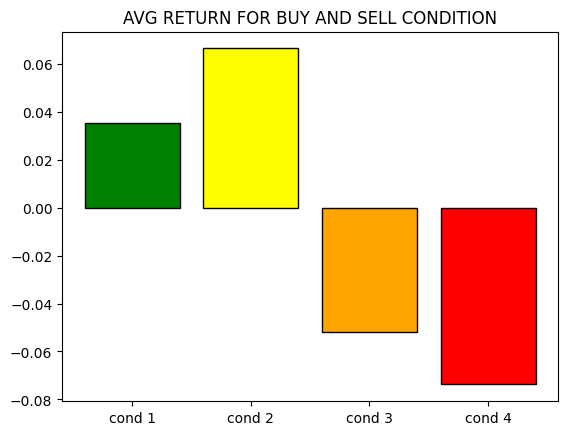

CURRENT CONDITION:  CURRENT: condition_2


In [465]:
# ASSETS PERFORMANCE IN EACH QUAD BAR CHART
# create sample data
categories = ['cond 1', 'cond 2', 'cond 3', 'cond 4']
values = [cond_1_perf_avg, cond_2_perf_avg, cond_3_perf_avg, cond_4_perf_avg]

# create the plot
plt.bar(categories, values, color=['green', 'yellow', 'orange', 'red'], edgecolor='black')

# add x-axis ticks and labels
plt.xticks(categories)

# add a title
plt.title('AVG RETURN FOR BUY AND SELL CONDITION')

# display the plot
plt.show()
print('CURRENT CONDITION: ', condition)

<AxesSubplot:>

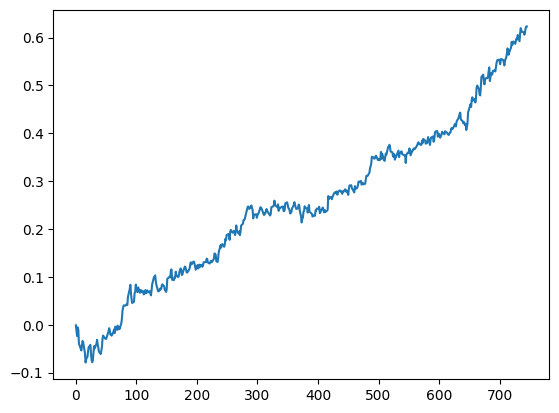

In [481]:
# EQUITY CURVE
#buy_perf.plot()

#cumulative returns
cond_1_perf['cumulative_returns'] = (1 + cond_1_perf[asset]).cumprod() - 1
cond_2_perf['cumulative_returns'] = (1 + cond_2_perf[asset]).cumprod() - 1
cond_3_perf['cumulative_returns'] = (1 + cond_3_perf[asset]).cumprod() - 1
cond_4_perf['cumulative_returns'] = (1 + cond_4_perf[asset]).cumprod() - 1

cond_2_perf['cumulative_returns'].plot()


C:\Users\Christopher!\AppData\Local\Temp\ipykernel_21696\3355529650.py:6: RuntimeWarning: invalid value encountered in true_divide
  drawdown = (cumulative_returns - peak) / peak
C:\Users\Christopher!\AppData\Local\Temp\ipykernel_21696\3355529650.py:6: RuntimeWarning: divide by zero encountered in true_divide
  drawdown = (cumulative_returns - peak) / peak


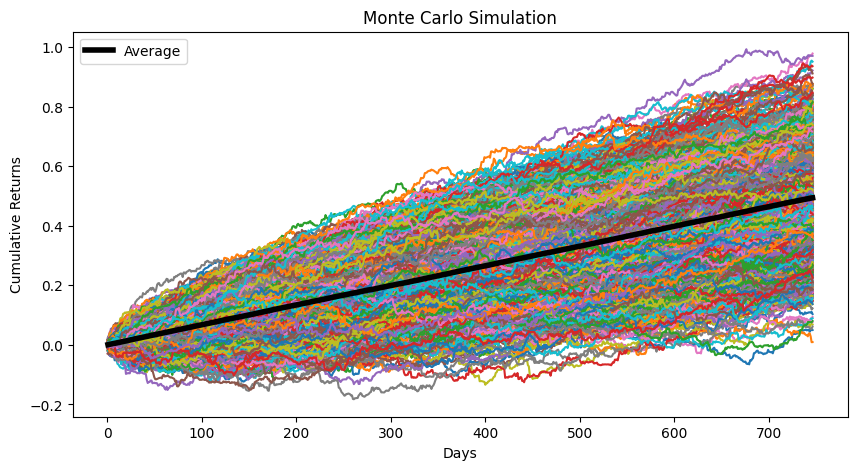

Average End Performance: 0.6366266122397048
Lowest Ending Performance: -0.002478175616092426
Best Ending Performance: 1.6287621411336914
Average Return Rate: 0.5735183199285075
Average Cumulative Return at 30 days: 0.01741276406184471
Average Cumulative Return at 90 days: 0.05172066363890599
LONG POSITIONS
Average Drawdown (%): -8.338112146589385
Max Drawdown (%): -63.63425145976542
SHORT POSITIONS DRAWDOWNS
Average Peak %: 0.315660087494635
Maximum Peak %: 1.6699143109628967


In [482]:
# MONTE CARLO TEST

# function to calculate drawdowns in percentage terms
def calculate_drawdowns_pct(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown

# monte carlo performance of asset curve in environment
################################
returns = cond_2_perf[asset]
#################################


# define parameters
num_simulations = 3000
trades_per_simulation = len(returns)
end_performance = np.zeros(num_simulations)
win_rates = np.zeros(num_simulations)
max_peak = np.zeros(num_simulations)
avg_peak = np.zeros(num_simulations)

# run monte carlo simulation
simulated_returns = np.zeros((num_simulations, trades_per_simulation))
for i in range(num_simulations):
    sample_returns = returns.sample(n=trades_per_simulation, replace=True)
    cumulative_returns = np.cumprod(1 + sample_returns) - 1
    end_performance[i] = cumulative_returns.iloc[-1]
    win_rates[i] = np.sum(sample_returns > 0) / trades_per_simulation
    
    # calculate cumulative returns for 30 days
    returns_30_days = sample_returns.iloc[:30]
    cumulative_returns_30_days = np.cumprod(1 + returns_30_days) - 1
    avg_cumulative_return_30_days = np.mean(cumulative_returns_30_days)
    
    # calculate cumulative returns for 90 days
    returns_90_days = sample_returns.iloc[:90]
    cumulative_returns_90_days = np.cumprod(1 + returns_90_days) - 1
    avg_cumulative_return_90_days = np.mean(cumulative_returns_90_days)
    
    simulated_returns[i,:] = np.cumsum(sample_returns)

    # calculate peak values
    peak_values = np.maximum.accumulate(cumulative_returns)
    max_peak[i] = np.max(peak_values)
    avg_peak[i] = np.mean(peak_values)

# calculate average simulation curve
mean_cumulative_returns = np.mean(simulated_returns, axis=0)

# calculate drawdowns for each simulation
simulated_drawdowns = np.apply_along_axis(calculate_drawdowns_pct, 1, simulated_returns)

# calculate drawdowns
cum_returns = np.cumprod(1 + sample_returns) - 1
high_watermark = np.maximum.accumulate(cum_returns)
drawdown = (cum_returns - high_watermark) / np.maximum(high_watermark, 1e-8)
max_drawdown = np.min(drawdown)
avg_drawdown = np.mean(drawdown)


# plot results
fig, ax = plt.subplots(figsize=(10,5))
for i in range(num_simulations):
    ax.plot(range(1, trades_per_simulation+1), simulated_returns[i,:])
ax.plot(range(1, trades_per_simulation+1), mean_cumulative_returns, linewidth=4, color='k', label='Average')
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Monte Carlo Simulation')
ax.legend()
plt.show()

# print statistics
print('Average End Performance:', np.mean(end_performance))
print('Lowest Ending Performance:', np.min(end_performance))
print('Best Ending Performance:', np.max(end_performance))
print('Average Return Rate:', np.mean(win_rates))
print('Average Cumulative Return at 30 days:', avg_cumulative_return_30_days)
print('Average Cumulative Return at 90 days:', avg_cumulative_return_90_days)
print('LONG POSITIONS')
print('Average Drawdown (%):', avg_drawdown*100)
print('Max Drawdown (%):', max_drawdown*100)
print('SHORT POSITIONS DRAWDOWNS')
print('Average Peak %:', np.mean(avg_peak))
print('Maximum Peak %:', np.max(max_peak))

